In [2]:
from futils import comparison
import pandas as pd
import rdkit.Chem as Chem
import importlib
importlib.reload(comparison)
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
from os.path import join
rcParams["font.size"] = 20

In [3]:
glide_data = pd.read_csv("../data/raw_data/cyp_screen/docking_results.csv", index_col = 0)
glide_data["site"] = np.nanargmin(glide_data.iloc[:, 1:7].to_numpy(), axis = 1)
glide_data["site"] = glide_data["site"].apply(lambda x: int(glide_data.columns[1:7][x].split("_")[-1]))
glide_data["min_score"] = glide_data.iloc[:, 1:7].min(axis = 1)
glide_data.rename(columns = {"Drug": "name"}, inplace = True)


In [4]:
out = []
for mol in Chem.SDMolSupplier("../data/gnina_processed/human_por/gnina.sdf"):
    props = mol.GetPropNames(includePrivate = True)
    out.append({})
    for prop in props:
        out[-1][prop] = mol.GetProp(prop)
    out[-1]["gnina_mol"] = mol
gnina_data = pd.DataFrame(out).rename(columns = {"_Name": "name"})

In [5]:
merged = gnina_data.merge(glide_data)
cutdown_data = merged[["CNNscore", "CNNaffinity", "CNNaffinity_variance", "CNN_VS", "min_score"]]
cutdown_data = cutdown_data.astype(float)
cutdown_data["site"] = merged["site"]

Text(0, 0.5, 'Glide best binding')

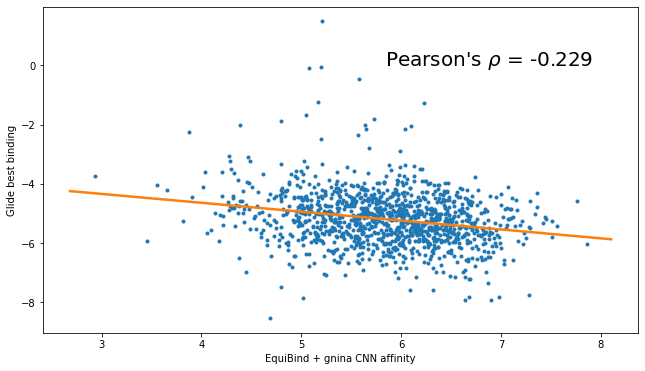

In [6]:
rcParams["lines.linewidth"] = 2.5
mask = cutdown_data["CNNscore"] > 0.0
fig, ax = plt.subplots(figsize = (16*2/3, 9*2/3))
comparison.Linreg(cutdown_data["CNNaffinity"][mask], cutdown_data["min_score"][mask], ax = ax, corpos = (0.75, 0.82))
plt.xlabel("EquiBind + gnina CNN affinity")
plt.ylabel("Glide best binding")

In [7]:
dir, _, files = next(os.walk("../data/glide_files"))
maes = [join(dir, file) for file in files if file.endswith(".mae")]

In [8]:
supps = {int(mae.split("/")[-1].split(".")[0]) : Chem.MaeMolSupplier(mae) for mae in maes}

In [9]:
mols = {key: list(supp) for key, supp in supps.items()}


[11:20:44] 

****
Invariant Violation
bad stereo bond
Violation occurred on line 205 in file /home/conda/feedstock_root/build_artifacts/rdkit_1651075184788/work/Code/GraphMol/FileParsers/MaeMolSupplier.cpp
Failed Expression: bond->getBondType() == Bond::DOUBLE
****

[11:20:44] 

****
Invariant Violation
bad chiral bond
Violation occurred on line 163 in file /home/conda/feedstock_root/build_artifacts/rdkit_1651075184788/work/Code/GraphMol/FileParsers/MaeMolSupplier.cpp
Failed Expression: bnd
****

[11:20:44] 

****
Invariant Violation
bad stereo bond
Violation occurred on line 205 in file /home/conda/feedstock_root/build_artifacts/rdkit_1651075184788/work/Code/GraphMol/FileParsers/MaeMolSupplier.cpp
Failed Expression: bond->getBondType() == Bond::DOUBLE
****

[11:20:44] 

****
Invariant Violation
bad stereo bond
Violation occurred on line 205 in file /home/conda/feedstock_root/build_artifacts/rdkit_1651075184788/work/Code/GraphMol/FileParsers/MaeMolSupplier.cpp
Failed Expression: bond->

In [10]:
full_dict = {}
for key, val in mols.items():
    full_dict[key] = {}
    for mol in val:
        if mol:
            name = mol.GetProp("_Name")
            if name in full_dict[key]:
                full_dict[key][name].append(mol)
            else:
                full_dict[key][name] = [mol]

# mols = {key: {mol.GetProp("_Name") : mol for mol in val if mol} for key, val in mols.items()}


In [11]:
def getter(name, site):
    try:
        out = full_dict[site][name][0]
    except KeyError:
        print("keyerror found", name)
        out = None
    return out

In [12]:
glide_data["glide_mol"] = glide_data.apply(lambda df: getter(df["name"], df["site"]), axis = 1)

keyerror found Ixazomib
keyerror found Fursultiamine
keyerror found Piritramide
keyerror found Articaine
keyerror found Etidocaine
keyerror found Chlorphenesin carbamate
keyerror found Asenapine
keyerror found Benznidazole
keyerror found Eliglustat
keyerror found Trilostane
keyerror found Tasimelteon
keyerror found Dexchlorpheniramine maleate
keyerror found Levocabastine
keyerror found Nateglinide
keyerror found Glimepiride


In [13]:
glide_data[glide_data["glide_mol"].notnull()].merge(gnina_data).set_index("name")

,score_1,score_2,score_3,score_5,score_7,score_8,site,min_score,glide_mol,_MolFileInfo,...,NumLipinskiHBD,Converged,Energy,minimizedAffinity,minimizedRMSD,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance,gnina_mol
name,,,,,,,,,,,,,,,,,,,,,
Formoterol,-7.931,-6.62,-6.969,-7.461,-5.144,-5.430,1,-7.931,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a8349e0>,,...,4,true,50.44457162554713,-1.36800,7.72504,0.3342451453,6.9002571106,2.3063774109,3.2444243431,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b56ff30>
Arformoterol,-7.918,-6.53,-6.170,-6.338,-6.009,-5.716,1,-7.918,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a834a30>,,...,4,true,49.81715564806976,0.89019,5.66102,0.4476853311,6.6359810829,2.9708313942,3.5443120003,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b4cd030>
Fenoterol,-7.714,-7.80,-7.394,-6.004,-5.651,-6.614,2,-7.800,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a056df0>,,...,5,true,38.262542894583056,-4.30002,8.32038,0.5631408095,6.6832184792,3.7635929585,4.1770768166,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b4cd670>
Ifenprodil,-7.576,-4.52,-5.938,-4.740,-5.615,-4.875,1,-7.576,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a834ad0>,,...,2,true,61.571362268273575,3.03832,6.49219,0.1804813296,6.3138008118,1.1395231485,3.9133548737,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b4581c0>
Metaraminol,-7.557,-6.66,-8.524,-6.494,-7.592,-4.499,3,-8.524,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a052940>,,...,4,true,21.10893985443994,-4.27946,6.82202,0.2508043051,4.6883859634,1.1758674383,8.3731565475,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b5f95d0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tetradecyl hydrogen sulfate (ester),-0.491,-2.03,-0.486,-0.361,-1.460,-0.923,2,-2.030,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a077ad0>,,...,1,true,32.36943763611302,-2.14280,7.69653,0.1472571045,6.0941910744,0.8974129558,3.7414443493,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b41fbc0>
Quaternium-24,0.874,0.80,-0.041,1.442,0.439,2.183,3,-0.041,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a834670>,,...,0,true,59.06077211033343,36.02168,7.63092,0.0048523531,5.1929206848,0.0251978841,7.4617385864,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b3d9a30>
Sodium lauryl sulfate,1.576,-0.47,0.132,1.320,0.743,0.521,2,-0.470,<rdkit.Chem.rdchem.Mol object at 0x7f4e7a078120>,,...,0,true,19.173413764991974,-1.95090,7.61329,0.4476288855,5.5768074989,2.4963400364,9.3868398666,<rdkit.Chem.rdchem.Mol object at 0x7f4e7b53bbc0>


In [88]:
from futils import poseview
importlib.reload(poseview)
import Bio.PDB as bp
from futils.biopython_utils import remove_hetatoms, load_prot

In [89]:
prot = load_prot("../data/raw_data/por_structures/3QE2_1_reduced.pdb")
remove_hetatoms(prot)

/home/qzj517/anaconda3/envs/equibind/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 10670
  PDBConstructionWarning,


In [90]:
test = glide_data[glide_data["glide_mol"].notnull()].merge(gnina_data)
idk = poseview.Poseviewer(prot, test, ["gnina_mol", "glide_mol"])
idk.widget

In [79]:
# [lig.clear() for lig in idk.ligcomponents]
bah = idk.ligcomponents[0]


In [80]:
bah.add_ball_and_stick(colorValue = "#F8766D")

In [74]:
idk.wid

NGLWidget(layout=Layout(height='500px', width='750px'), n_components=3)

In [38]:
center_gnina = np.stack(test["gnina_mol"].apply(lambda mol: mol.GetConformer().GetPositions().mean(axis = 0))).mean(axis = 0)

In [39]:
center_glide = np.stack(test["glide_mol"].apply(lambda mol: mol.GetConformer().GetPositions().mean(axis = 0))).mean(axis = 0)

<AxesSubplot:>

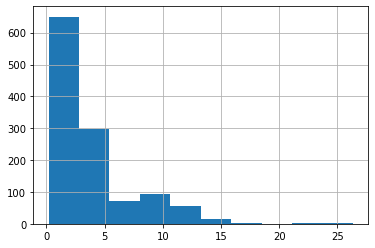

In [40]:
test["gnina_mol"].apply(lambda mol: np.sqrt(((mol.GetConformer().GetPositions().mean(axis = 0) - center_gnina)**2).sum())).hist()

<AxesSubplot:>

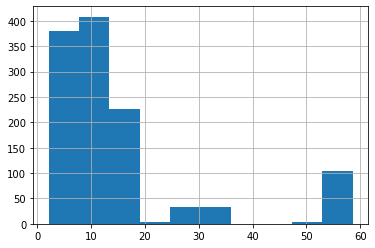

In [41]:
test["glide_mol"].apply(lambda mol: np.sqrt(((mol.GetConformer().GetPositions().mean(axis = 0) - center_glide)**2).sum())).hist()

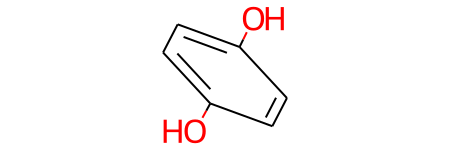

In [18]:
test.loc[76]["gnina_mol"]

In [58]:
idk.wid._ngl_component_names

['nglview.adaptor.BiopythonStructure',
 'nglview.adaptor.RdkitStructure',
 'nglview.adaptor.RdkitStructure']

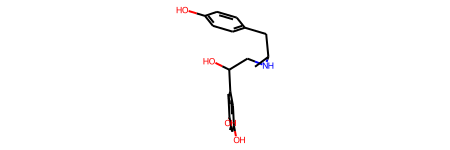

In [47]:
test.loc[2, "gnina_mol"]

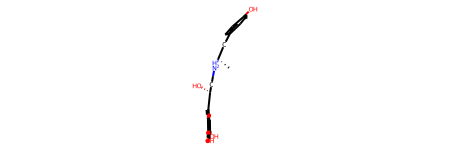

In [48]:
test.loc[2, "glide_mol"]

In [31]:
idk.ligcomponents

In [272]:
glide_data.set_index("name").loc["Ixazomib"]["mol"]

In [247]:
i = 0
j = 0
for row in glide_data.itertuples():
    try:
        glide_scores = list(map(lambda mol: float(mol.GetProp("r_i_docking_score")), full_dict[row.site][row.name]))
        if abs(glide_scores[0] - row.min_score) > 0.01:
            print(row.name, row.site, glide_scores[0], row.min_score)
    except KeyError as e:
        print(e)
        pass
    # for mol in full_dict[row.site][row.name]:
    #     value_from_mae = round(float(mol.GetProp("r_i_docking_score")), 3)
    #     if value_from_mae == row.min_score:    
    #         break
    # else:
    #     raise ValueError

'Ixazomib'
'Fursultiamine'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'Piritramide'
'r_i_docking_score'
'Articaine'
'Etidocaine'
'r_i_docking_score'
'r_i_docking_score'
'Chlorphenesin carbamate'
'r_i_docking_score'
'Asenapine'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'Benznidazole'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'Eliglustat'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'Trilostane'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'Tasimelteon'
'r_i_docking_score'
'r_i_docking_score'
'Dexchlorpheniramine maleate'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_docking_score'
'r_i_dockin

In [215]:
row.min_score

-7.066

In [196]:
{name: full_dict[row.site][row.name][0].GetProp(name) for name in full_dict[row.site][row.name][0].GetPropNames()}

{'s_epik_cmdline': 'J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLW50JywgJy1tYScsICcyMDAnLCAnLWltYWUnLCAnPGluZmlsZS5tYWU+JywgJy1vbWFlJywgJzxvdXRmaWxlLm1hZT4n',
 's_epik_input': 'W05IMl1bQ0BIXShbQ0gzXSlbQ0BIXShbT0hdKWMxYyhPW0NIM10pW2NIXVtjSF1jKFtjSF0xKU9bQ0gzXQ==',
 's_lp_Force_Field': 'OPLS3e',
 's_lp_Variant': 'Methoxamine-1',
 's_m_Source_File': 'test_3D_opt_1216.sdf',
 's_m_Source_Path': '/Users/xvk760/Desktop/Nikos_Hatzakis/Docking/190524 Library prep',
 's_m_entry_id': '4700',
 's_m_entry_name': 'test_3D_opt_1216.339',
 's_m_job_name': 'ligprep_3D_opt_1216',
 's_m_source_file': 'ligprep_3D_opt_1216.maegz',
 's_m_subgroup_title': 'ligprep_3D_opt_1216-out1',
 's_m_subgroupid': 'ligprep_3D_opt_1216-out1',
 's_sd_Converged': 'true',
 's_sd_DATABASE\\_ID': 'DB00723',
 's_sd_GENERIC\\_NAME': 'Methoxamine',
 'r_epik_Charging_Adjusted_Penalty': '0.023426020034482999',
 'r_epik_Ionization_Penalty': '0.0132',
 'r_epik_Ionization_Penalty_Charging': '0.0132',
 'r_epik_Ionization_Penalty_Neutral': 

In [206]:
row.site

8

In [205]:
row.name

'Lauric Acid'

In [198]:
full_dict[row.site][row.name][1].GetProp("r_i_docking_score")

KeyError: 'r_i_docking_score'

In [184]:
[mol.GetProp("r_i_docking_score") for mol in full_dict[row.site][row.name]]

['-7.7972676384011503', '-6.0781123559716601', '-5.6342203007940901']

In [182]:
row.site

2

In [180]:
row.name

'Fenoterol'

In [86]:
from matplotlib.colors import TABLEAU_COLORS

In [87]:
TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [159]:
full_dict[entry["site"]][entry["name"]][0].GetProp("r_i_docking_score")

'-7.9314646350584903'

In [161]:
-7.931

-7.931

In [154]:
{name: full_dict[entry["site"]][entry["name"]][0].GetProp(name) for name in full_dict[entry["site"]][entry["name"]][0].GetPropNames()}

{'s_epik_cmdline': 'J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLW50JywgJy1tYScsICcyMDAnLCAnLWltYWUnLCAnPGluZmlsZS5tYWU+JywgJy1vbWFlJywgJzxvdXRmaWxlLm1hZT4n',
 's_epik_input': 'Tz1bQ0hdW05IXWMoYyhbT0hdKVtjSF1bY0hdMSlbY0hdYzFbQ0BIXShbT0hdKVtDSDJdW05IXVtDQEhdKFtDSDNdKVtDSDJdYzJbY0hdW2NIXWMoT1tDSDNdKVtjSF1bY0hdMg==',
 's_i_glide_gridfile': 'glide-grid_1',
 's_lp_Force_Field': 'OPLS3e',
 's_lp_Variant': 'Formoterol-1',
 's_m_Source_File': 'test_3D_opt_1216.sdf',
 's_m_Source_Path': '/Users/xvk760/Desktop/Nikos_Hatzakis/Docking/190524 Library prep',
 's_m_entry_id': '12532',
 's_m_entry_name': 'test_3D_opt_1216.495',
 's_m_job_name': 'glide-grid_1_drugbank_docking',
 's_m_source_file': 'ligprep_3D_opt_1216.maegz',
 's_m_subgroup_title': 'glide-grid_1_drugbank_docking_pv1',
 's_m_subgroupid': 'glide-grid_1_drugbank_docking_pv1',
 's_sd_Converged': 'true',
 's_sd_DATABASE\\_ID': 'DB00983',
 's_sd_GENERIC\\_NAME': 'Formoterol',
 'r_epik_Charging_Adjusted_Penalty': '0.0276634358614763',
 'r_epik_Io

In [156]:
entry["min_score"]

-7.931

In [140]:
full_dict

{5: {'3QE2 - preprocessed': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5260080>],
  'Formoterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba52609e0>,
  'Levosalbutamol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5260ad0>],
  'Metaraminol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5260f80>,
  'Pirbuterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262d00>,
  'Arformoterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262670>,
  'Carvedilol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba52628a0>,
  'Silodosin': [<rdkit.Chem.rdchem.Mol at 0x7f6ba52627b0>],
  'Ephedrine': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262e90>,
  'Phenylpropanolamine': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262df0>,
  'Olodaterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262a80>,
  'Mirabegron': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262c60>,
  'Palbociclib': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262c10>,
  'Vilanterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262990>],
  'Fenoterol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5262f30>,
  'Salbutamol': [<rdkit.Chem.rdchem.Mol at 0x7f6ba5379ee0>],
  'Maprot

In [139]:
mols[1]

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ...]